In [1]:
import os
if os.name == 'nt':
    %env DOC=C:\Users\BK\Documents
else:
    %env DOC=/Users/muuzh/Documents

from AMI import automutual_info_single, automutual_info, automutual_info_k1


env: DOC=/Users/muuzh/Documents
/Users/muuzh/Documents/JIDT/infodynamics.jar


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import seaborn as sns
import pandas as pd
import time
import itertools
import scipy.stats as stats
import jpype
import measures as nolds
import datasets as datasets



A positive Lyapunov exponent indicates that the system exhibits chaotic behavior. In this case, nearby trajectories in the phase space diverge exponentially over time, which is a signature of strong nonlinearity. The larger the positive exponent, the more rapid the divergence, and the stronger the chaotic behavior and nonlinearity.

ISSUE: A higher order linear term lead to nonlinerity lower order detection.

High LE -> each step deviate more from the original trajectory -> more nonlinear (higher degree of nonlinearity)

In [3]:
# a function to do poincare plot
def poincare_plot(data, stride=1):
    """
    Create a Poincare plot from a time series.

    Parameters
    ----------
    data : array_like
        The time series data.
    stride : int, optional
        The stride between consecutive points in the time series. Default is 1.

    Returns
    -------
    tuple
        A tuple containing the x and y coordinates of the Poincare plot.
    """
    x = data[:-stride]
    y = data[stride:]
    return x, y

In [40]:
def plot_lyap(maptype):
  # local import to avoid dependency for non-debug use
  import matplotlib.pyplot as plt

  x_start = 0.1
  n = 140
  nbifur = 40
  if maptype == "logistic":
    param_name = "r"
    param_range = np.arange(2, 4, 0.01)
    full_data = np.array([
      np.fromiter(datasets.logistic_map(x_start, n, r), dtype="float32")
      for r in param_range
    ])

    lambdas = [
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(full_data, param_range)
    ]
  elif maptype == "tent":
    param_name = "$\\mu$"
    param_range = np.arange(0, 2, 0.01)
    full_data = np.array([
      np.fromiter(datasets.tent_map(x_start, n, mu), dtype="float32")
      for mu in param_range
    ])

    lambdas = np.log(param_range, where=param_range > 0)
    lambdas[np.where(param_range <= 0)] = np.nan
  else:
    # raise Error("maptype %s not recognized" % maptype)
    pass

  kwargs_e = {"emb_dim": 6, "matrix_dim": 2}
  kwargs_r = {"emb_dim": 6, "lag": 2, "min_tsep": 20, "trajectory_len": 20}
  # algorithm of Eckmann
  lambdas_e = [max(nolds.lyap_e(d, **kwargs_e)) for d in full_data]
  # ################
  # 
  # algorithm of Rosenstein
  lambdas_r = [nolds.lyap_r(d, **kwargs_r) for d in full_data]
  # ################
  bifur_x = np.repeat(param_range, nbifur)
  bifur = np.reshape(full_data[:, -nbifur:], nbifur * param_range.shape[0])

  plt.figure(figsize=(10, 6))
  plt.title("Lyapunov exponent of %s map" % maptype)
  plt.plot(param_range, lambdas, "b-", label="theoretical LE")
  elab = "Eckmann method"
  rlab = "largest LE, Rosenstein method"
  plt.plot(param_range, lambdas_e, color="#00AAAA", label=elab)
  plt.plot(param_range, lambdas_r, color="#AA00AA", label=rlab)
  plt.plot(param_range, np.zeros(len(param_range)), "g--")
  plt.plot(bifur_x, bifur, "ro", alpha=0.1, label="bifurcation plot")
  plt.ylim((-2, 2))
  plt.xlabel(param_name)
  plt.ylabel("LE")
  plt.legend(loc="best")
  plt.show()

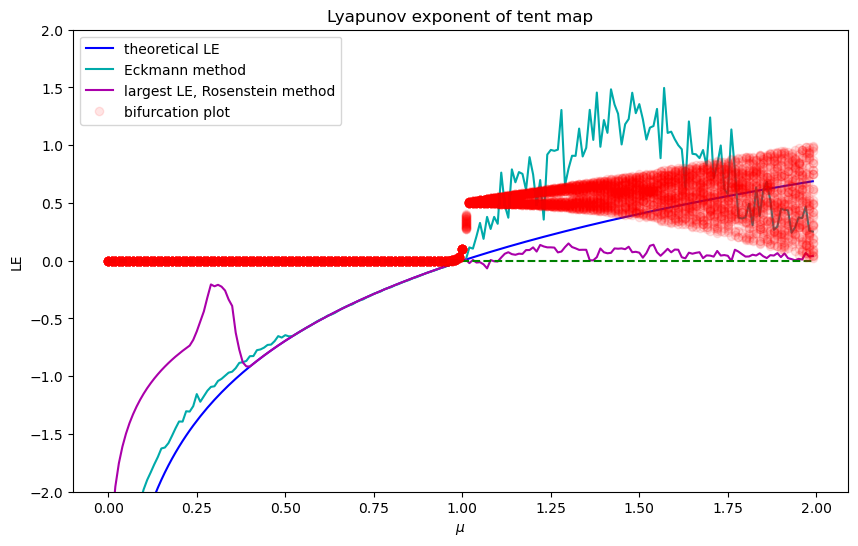

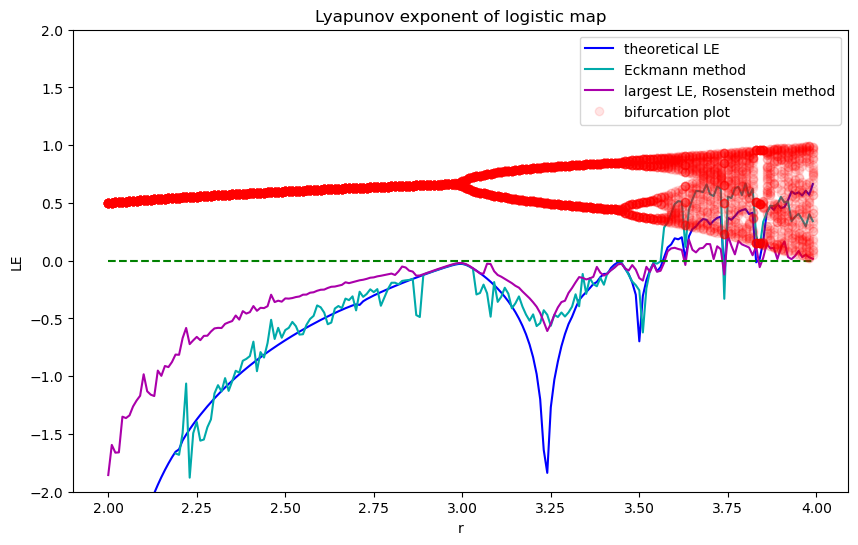

In [41]:
plot_lyap("tent")
plot_lyap("logistic")

compute AC and AMI for tent map and logistic map

In [4]:
def poincare_plot(data, stride=1):
    """
    Create a Poincare plot from a time series.

    Parameters
    ----------
    data : array_like
        The time series data.
    stride : int, optional
        The stride between consecutive points in the time series. Default is 1.

    Returns
    -------
    tuple
        A tuple containing the x and y coordinates of the Poincare plot.
    """
    x = data[:-stride]
    y = data[stride:]
    return x, y

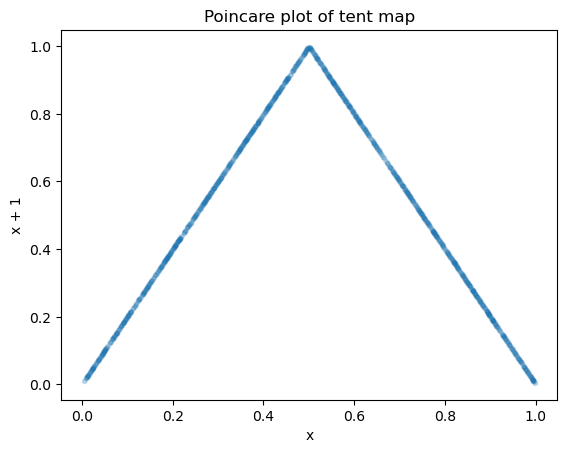

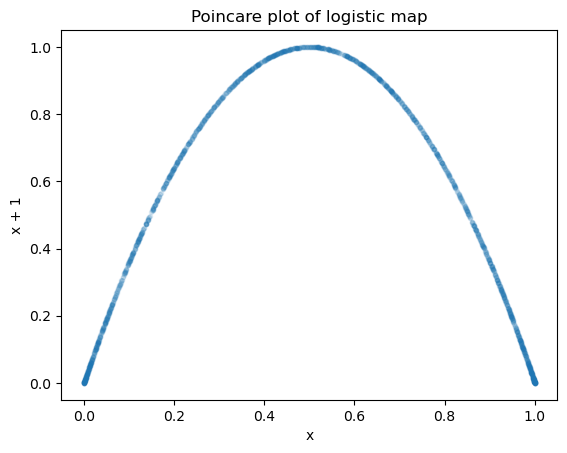

In [5]:
x_start = 0.1
series_length = 2200
tent_a_num = 400
tent_logistic_num = 400

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])


# delete the first 200 points for each series
tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

x, y = poincare_plot(tent_full_data[-1], stride=1)
plt.figure()
plt.scatter(x, y, marker='.',alpha=0.1)
plt.xlabel("x")
plt.ylabel("x + 1")
plt.title("Poincare plot of tent map")
plt.show()

x, y = poincare_plot(logistic_full_data[-1], stride=1)
plt.figure()
plt.scatter(x, y, marker='.',alpha=0.1)
plt.xlabel("x")
plt.ylabel("x + 1")
plt.title("Poincare plot of logistic map")
plt.show()

In [6]:
tentAMI1 = automutual_info(tent_full_data, 1, 3)
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

In [7]:
tentAC1 = np.array([
    c
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])




In [8]:
tentAMI1_k2 = automutual_info(tent_full_data, 1, 3)
logisticAMI1_k2 = automutual_info(logistic_full_data, 1, 3)

tentAMI1_k1 = automutual_info_k1(tent_full_data, 1, 3)
logisticAMI1_k1 = automutual_info_k1(logistic_full_data, 1, 3)


Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

In [9]:
tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]
tentAMI1Chaotic_k1 = tentAMI1_k1[tentChaoticIdx]
tentAMI1Chaotic_k2 = tentAMI1_k2[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
logisticAMI1Chaotic_k1 = logisticAMI1_k1[logisticChaoticIdx]
logisticAMI1Chaotic_k2 = logisticAMI1_k2[logisticChaoticIdx]



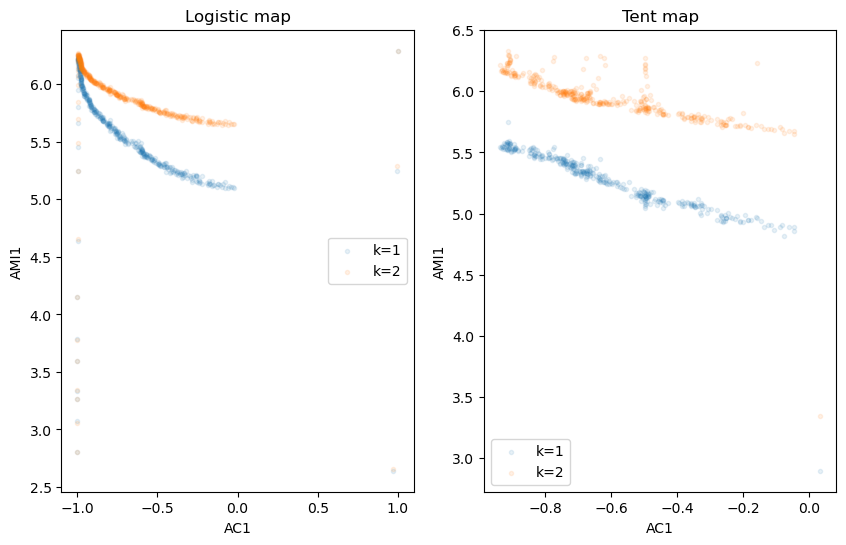

In [10]:
# plot AMI1 vs AC1 on the same figure, logistic map and tent map in different subplots
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Logistic map")
# use legends to distinguish different k
plt.scatter(tentAC1Chaotic, tentAMI1Chaotic_k1, marker='.',alpha=0.1 ,label="k=1")
plt.scatter(tentAC1Chaotic, tentAMI1Chaotic_k2, marker='.',alpha=0.1, label="k=2")
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.title("Tent map")
plt.scatter(logisticAC1Chaotic, logisticAMI1Chaotic_k1, marker='.',alpha=0.1, label="k=1")
plt.scatter(logisticAC1Chaotic, logisticAMI1Chaotic_k2, marker='.',alpha=0.1, label="k=2")
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.legend(loc="best")
plt.show()


In [11]:
tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)


tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]
tentAMI1Chaotic = tentAMI1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]


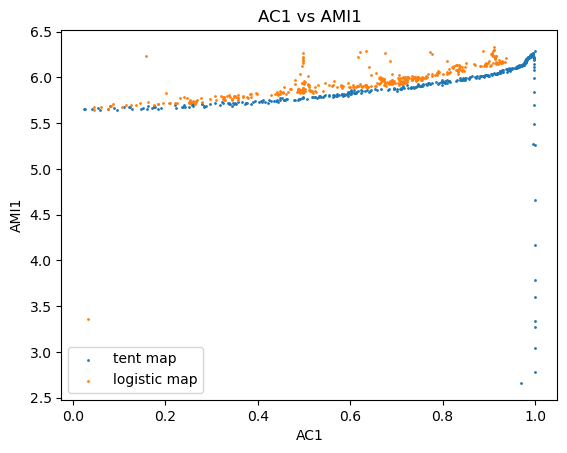

In [12]:
plt.figure()
plt.scatter(np.abs(tentAC1Chaotic), tentAMI1Chaotic, s=1)
plt.scatter(np.abs(logisticAC1Chaotic), logisticAMI1Chaotic, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("AC1 vs AMI1")
plt.legend(["tent map", "logistic map"])
plt.show()



In [13]:
a_num = 400
lag1para = np.linspace(0, 1, a_num)
AR_series_length = 2000
ARpara = [np.r_[1, -arparams] for arparams in lag1para]
# For each parameter, generate 20 AR time series
# Use a 3d numpy array to store the results, with placeholder nan

AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(AR_series_length) for ar in ARpara])

AR1AC1 = np.array([
    acf(series, nlags=1)[1]
    for series in AR1matrix
])

AR1AMI1 = automutual_info(AR1matrix, 1, 3)


Processing:   0%|          | 0/400 [00:00<?, ?it/s]

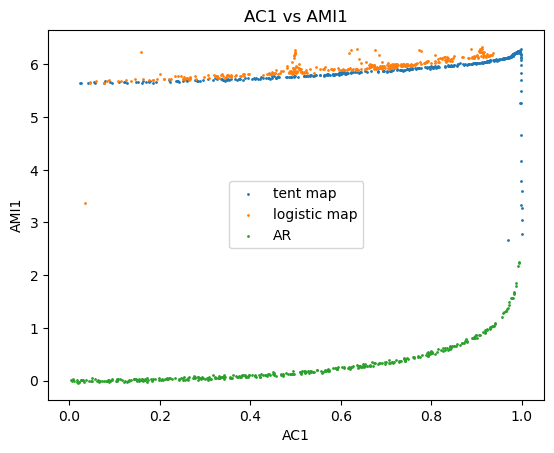

In [16]:
plt.figure()
plt.scatter(np.abs(tentAC1Chaotic), tentAMI1Chaotic, s=1)
plt.scatter(np.abs(logisticAC1Chaotic), logisticAMI1Chaotic, s=1)
plt.scatter(np.abs(AR1AC1), AR1AMI1, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("AC1 vs AMI1")
plt.legend(["tent map", "logistic map", "AR"])
plt.show()

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

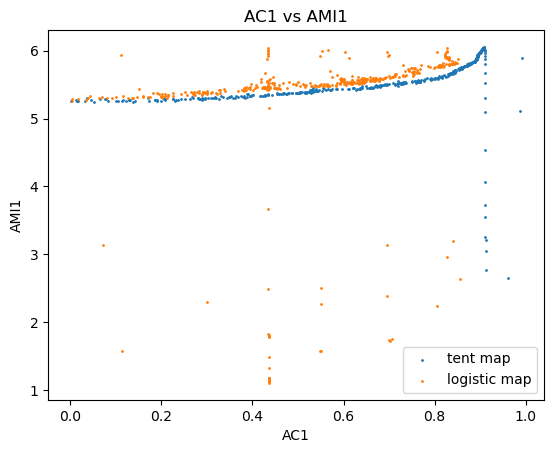

In [177]:
a_num = 100
lag1para = np.linspace(0, 1, a_num)
AR_series_length = 100
ARpara = [np.r_[1, -arparams] for arparams in lag1para]
# For each parameter, generate 20 AR time series
# Use a 3d numpy array to store the results, with placeholder nan

AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(AR_series_length) for ar in ARpara])

tenttest1 = np.array([
    np.hstack((stats.zscore(currentSeries), stats.zscore(AR1matrix[90])))
    for currentSeries in tent_full_data
])

logistictest1 = np.array([
    np.hstack((stats.zscore(currentSeries), stats.zscore(AR1matrix[90])))
    for currentSeries in logistic_full_data
])


tentTestAMI1 = automutual_info(tenttest1, 1, 3)
logisticTestAMI1 = automutual_info(logistictest1, 1, 3)

tentTestAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tenttest1
])
logisticTestAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistictest1
])

plt.figure()
plt.scatter(np.abs(tentTestAC1), tentTestAMI1, s=1)
plt.scatter(np.abs(logisticTestAC1), logisticTestAMI1, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("AC1 vs AMI1")
plt.legend(["tent map", "logistic map"])
plt.show()




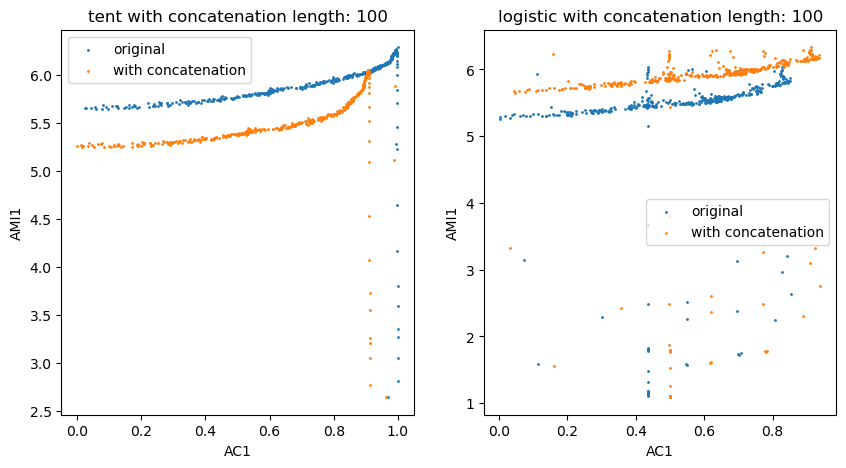

In [185]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.abs(tentAC1), tentAMI1, s=1)
plt.scatter(np.abs(tentTestAC1), tentTestAMI1, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("tent with concatenation length: %d"%AR_series_length)
plt.legend(["original", "with concatenation"])


plt.subplot(1, 2, 2)
plt.scatter(np.abs(logisticTestAC1), logisticTestAMI1, s=1)
plt.scatter(np.abs(logisticAC1), logisticAMI1, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("logistic with concatenation length: %d"%AR_series_length)
plt.legend(["original", "with concatenation"])
plt.show()

Text(0.5, 1.0, 'concatenation length 100')

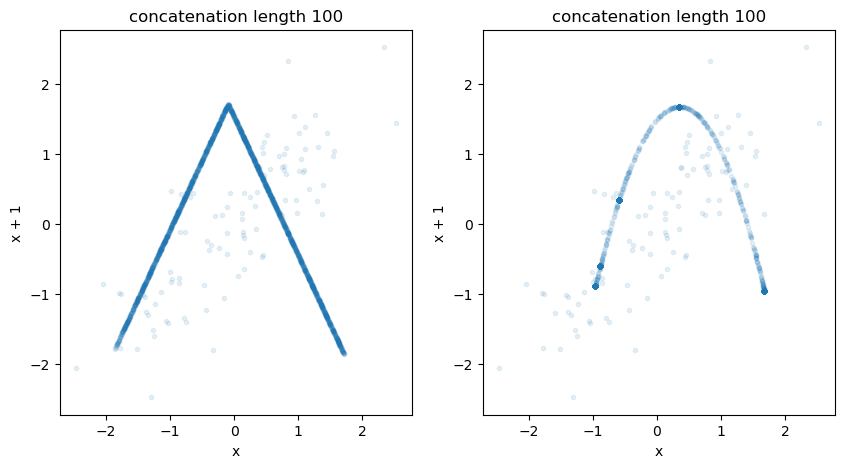

In [178]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
x, y = poincare_plot(tenttest1[-10], stride=1)
plt.scatter(x, y, marker='.',alpha=0.1)
plt.xlabel("x")
plt.ylabel("x + 1")
plt.title("concatenation length %d"%AR_series_length)

plt.subplot(1, 2, 2)
x, y = poincare_plot(logistictest1[-10], stride=1)
plt.scatter(x, y, marker='.',alpha=0.1)
plt.xlabel("x")
plt.ylabel("x + 1")
plt.title("concatenation length %d"%AR_series_length)

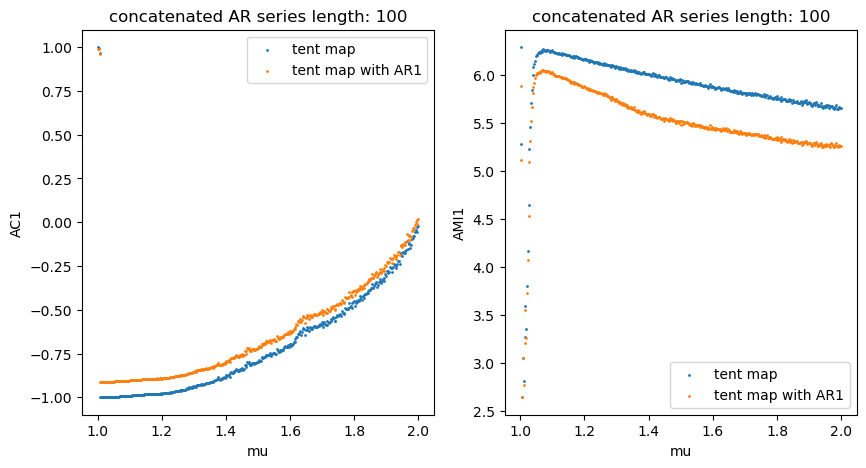

In [179]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(param_range_tent, tentAC1, s=1)
plt.scatter(param_range_tent, tentTestAC1, s=1)
plt.xlabel("mu")
plt.ylabel("AC1")
plt.title("concatenated AR series length: %d" % AR_series_length)
plt.legend(["tent map", "tent map with AR1"])

plt.subplot(1, 2, 2)
plt.scatter(param_range_tent, tentAMI1, s=1)
plt.scatter(param_range_tent, tentTestAMI1, s=1)
plt.xlabel("mu")
plt.ylabel("AMI1")
plt.title("concatenated AR series length: %d" % AR_series_length)
plt.legend(["tent map", "tent map with AR1"])
plt.show()


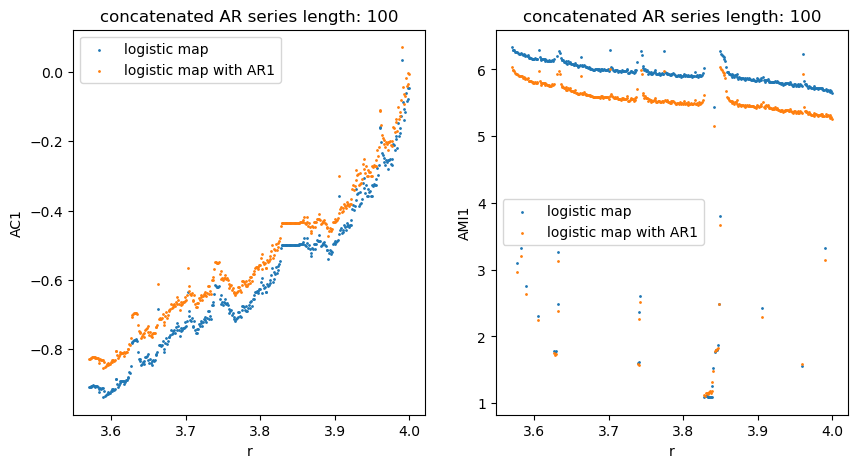

In [180]:
# do the same for logistic map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(param_range_logistic, logisticAC1, s=1)
plt.scatter(param_range_logistic, logisticTestAC1, s=1)
plt.xlabel("r")
plt.ylabel("AC1")
plt.title("concatenated AR series length: %d"%AR_series_length)
plt.legend(["logistic map", "logistic map with AR1"])

plt.subplot(1, 2, 2)
plt.scatter(param_range_logistic, logisticAMI1, s=1)
plt.scatter(param_range_logistic, logisticTestAMI1, s=1)
plt.xlabel("r")
plt.ylabel("AMI1")
plt.title("concatenated AR series length: %d"%AR_series_length)
plt.legend(["logistic map", "logistic map with AR1"])
plt.show()


Now change the length for AR

/var/folders/tb/pt6y5vkj3fv9hx3q1df1nh6w0000gn/T/ipykernel_6870/594772857.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(AR_series_length) for AR_series_length in AR_series_length_range])
/var/folders/tb/pt6y5vkj3fv9hx3q1df1nh6w0000gn/T/ipykernel_6870/594772857.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  logistictest1 = np.array([


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

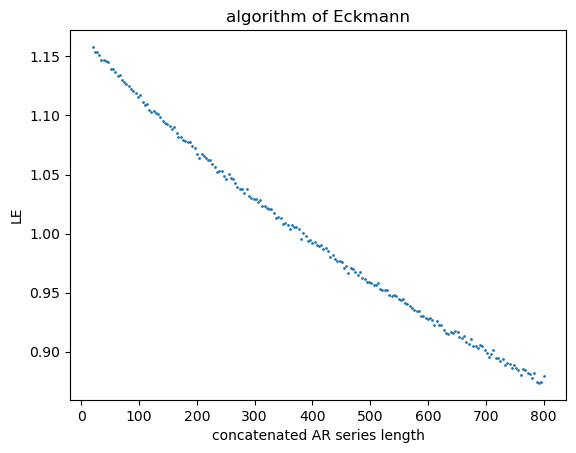

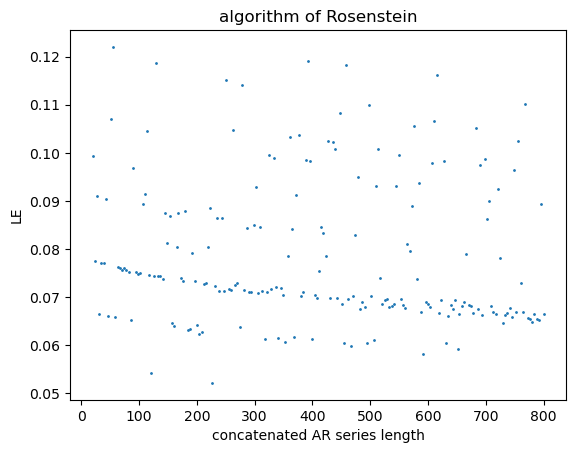

In [231]:
a_num = 100
lag1para = np.linspace(0, 1, a_num)
AR_series_length_range = np.linspace(20, 800, 200,dtype=int)
ARpara = [np.r_[1, -arparams] for arparams in lag1para]
ar = ARpara[90]
# For each parameter, generate 20 AR time series
# Use a 3d numpy array to store the results, with placeholder nan

AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(AR_series_length) for AR_series_length in AR_series_length_range])
logistictest1 = np.array([
    np.hstack((stats.zscore(logistic_full_data[-50]), stats.zscore(AR)))
    for AR in AR1matrix
])



# testAMI = [automutual_info_single(series, 1, 3) for series in tqdm(logistictest1)]
# comput LE for each series
kwargs_e = {"emb_dim": 6, "matrix_dim": 2}
lambdas_e = [max(nolds.lyap_e(d, **kwargs_e)) for d in tqdm(logistictest1)]

kwargs_r = {"emb_dim": 6, "lag": 2, "min_tsep": 20, "trajectory_len": 20}
lambdas_r = [nolds.lyap_r(d, **kwargs_r) for d in tqdm(logistictest1)]

plt.figure()
plt.scatter(AR_series_length_range, lambdas_e, s=1)
plt.xlabel("concatenated AR series length")
plt.ylabel("LE")
plt.title("algorithm of Eckmann")
plt.show()

plt.figure()
plt.scatter(AR_series_length_range, lambdas_r, s=1)
plt.xlabel("concatenated AR series length")
plt.ylabel("LE")
plt.title("algorithm of Rosenstein")
plt.show()





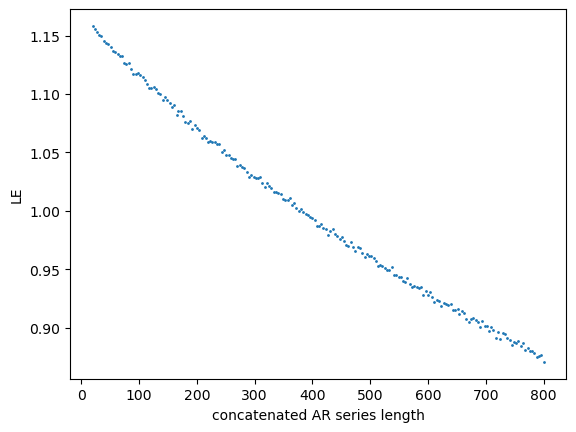

In [230]:
plt.figure()
plt.scatter(AR_series_length_range, lambdas_e, s=1)
plt.xlabel("concatenated AR series length")
plt.ylabel("LE")
plt.show()